# Finite Differencing

## Setup

In [1]:
pwd()

"/Users/eschnett/txt/Courses/CompPhys2018/jl/FiniteDifferencing"

In [2]:
]activate .

In [3]:
]add Plots

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/txt/Courses/CompPhys2018/jl/FiniteDifferencing/Project.toml`
 [no changes]
  Updating `~/txt/Courses/CompPhys2018/jl/FiniteDifferencing/Manifest.toml`
 [no changes]


In [4]:
]status

    Status `~/txt/Courses/CompPhys2018/jl/FiniteDifferencing/Project.toml`
  [91a5bcdd] Plots v0.21.0


In [5]:
using Plots

## Piecewise Linear Continuous Functions

We approximate functions by a piecewise linear continuous approximation, with a regular grid spacing.

In [6]:
# A piecewise linear continuous function mapping a type T to a type U
struct PLCFun{T,U}
    # Domain: [0; 1]
    points::Vector{U}
end

In [7]:
# Functions can be scaled and added
function Base. *(a::U, f::PLCFun{T, U})::PLCFun{T, U} where {T, U}
    PLCFun{T, U}(a .* f.points)
end
function Base. +(f::PLCFun{T, U}, g::PLCFun{T, U})::PLCFun{T, U} where {T, U}
    @assert length(f.points) == length(g.points)
    PLCFun{T, U}(f.points .+ g.points)
end

In [8]:
# Calculate the x coordinates of the endpoints of the lines
function xcoord(::Type{T}, nlines::Int, i::Int)::T where {T}
    @assert 1 <= i <= nlines + 1
    dx = 1 / nlines
    x = (i-1) * dx
    x
end

xcoord (generic function with 1 method)

In [9]:
# The inverse of "xcoord": Determine the line segment on which a particular x coordinate lies
function lineidx(f::PLCFun{T, U}, x::T)::Int where {T, U}
    @assert 0 <= x <= 1
    nlines = length(f.points) - 1
    dx = 1 / nlines
    i = floor(Int, x / dx) + 1
    i = max(1, i)
    i = min(nlines, i)
    i
end

lineidx (generic function with 1 method)

In [10]:
# Convert a general Julia function into a PLCFun. We need to specify the types T and U,
# as well as the number of line segments to use.
function samplePLC(::Type{T}, ::Type{U}, nlines::Int, f::Function)::PLCFun{T, U} where {T, U}
    ys = U[f(xcoord(T, nlines, i)) for i in 1:nlines+1]
    PLCFun{T, U}(ys)
end

samplePLC (generic function with 1 method)

In [11]:
# Linear interpolation between two points
function linterp(x1::T, y1::U, x2::T, y2::U, x::T)::U where {T, U}
    y1 * (x - x2) / (x1 - x2) + y2 * (x - x1) / (x2 - x1)
end

linterp (generic function with 1 method)

In [12]:
# Evaluate a PLCFun at point x
function evaluate(f::PLCFun{T,U}, x::T)::U where {T, U}
    @assert 0 <= x <= 1
    nlines = length(f.points) - 1
    # Find out on which line segment the point lies
    i = lineidx(f, x)
    # Interpolate between the two endpoints of the line segment
    x1 = xcoord(T, nlines, i)
    x2 = xcoord(T, nlines, i+1)
    y1 = f.points[i]
    y2 = f.points[i+1]
    y = linterp(x1, y1, x2, y2, x)
    y
end

evaluate (generic function with 1 method)

In [13]:
# Calculate the derivative of a PLCFun, using a right-biased derivative
function derivRight(f::PLCFun{T, U})::PLCFun{T, U} where {T, U}
    nlines = length(f.points) - 1
    dx = 1 / nlines
    ys = [[(f.points[i+1] - f.points[i]) / dx for i in 1:nlines];
          (f.points[end] - f.points[end-1]) / dx]
    PLCFun{T, U}(ys)
end

derivRight (generic function with 1 method)

### Example use of PLCFun

In [14]:
fsinpi = samplePLC(Float64, Float64, 4, sinpi)

PLCFun{Float64,Float64}([0.0, 0.707107, 1.0, 0.707107, 0.0])

In [15]:
(evaluate(fsinpi, 0.3333), sinpi(0.3333))

(0.8046988016951899, 0.8659730391584589)

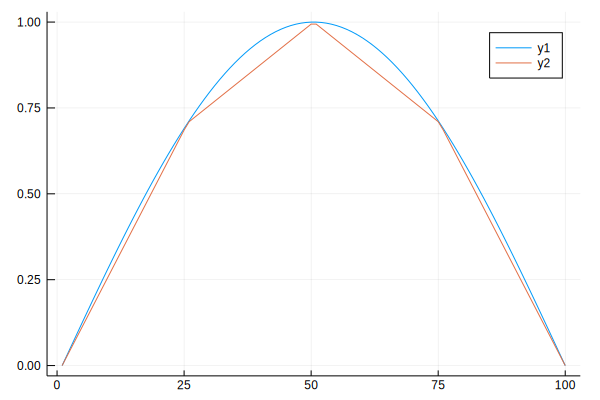

In [16]:
xs = collect(range(0, stop=1, length=100))
plot(sinpi.(xs))
plot!([evaluate(fsinpi, x) for x in xs])

## Advection Equation

In [17]:
# The state vector describing how we evolve the advection equation in time
struct AdvectionState{T}
    time::T
    u::PLCFun{T, T}
end

In [18]:
# A Gaussian, centred at x=1/2, with a width of 1/10
function gaussian(x::T)::T where {T}
    exp(- ((x - 0.5) * 10)^2)
end

gaussian (generic function with 1 method)

In [19]:
# Define initial conditions: A Gaussian at t=0
function initialGaussian(nlines::Int)::AdvectionState{Float64}
    t = 0
    u = samplePLC(Float64, Float64, nlines, gaussian)
    AdvectionState{Float64}(t, u)
end

initialGaussian (generic function with 1 method)

In [20]:
s0 = initialGaussian(8)

AdvectionState{Float64}(0.0, PLCFun{Float64,Float64}([1.38879e-11, 7.81149e-7, 0.00193045, 0.209611, 1.0, 0.209611, 0.00193045, 7.81149e-7, 1.38879e-11]))

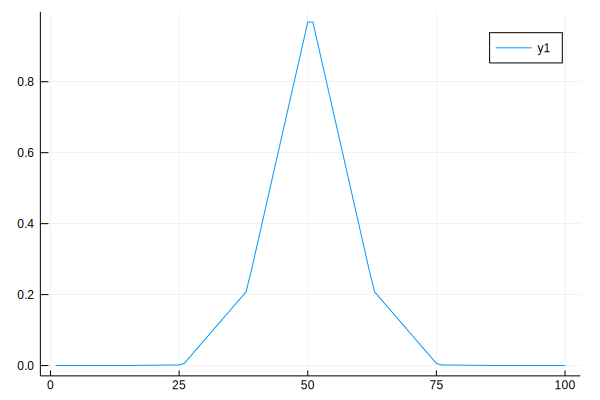

In [21]:
plot([evaluate(s0.u, x) for x in xs])

In [22]:
# The RHS (Right Hand Side) of the advection equation, including boundary conditions
function rhsAdvection(s::AdvectionState{T})::AdvectionState{T} where {T}
    t = s.time
    u = s.u
    nlines = length(u.points)
    # Calculate spatial derivative
    ux = derivRight(u)
    # Define time derivative as the spatial derivative almost everywhere,
    # except at the right boundary where we set the time derivative to zero
    ut = PLCFun{T, T}([[ux.points[i] for i in 1:nlines]; 0])
    AdvectionState{T}(t, ut)
end

rhsAdvection (generic function with 1 method)

In [23]:
r0 = rhsAdvection(s0)

AdvectionState{Float64}(0.0, PLCFun{Float64,Float64}([6.24908e-6, 0.0154374, 1.66145, 6.32311, -6.32311, -1.66145, -0.0154374, -6.24908e-6, -6.24908e-6, 0.0]))

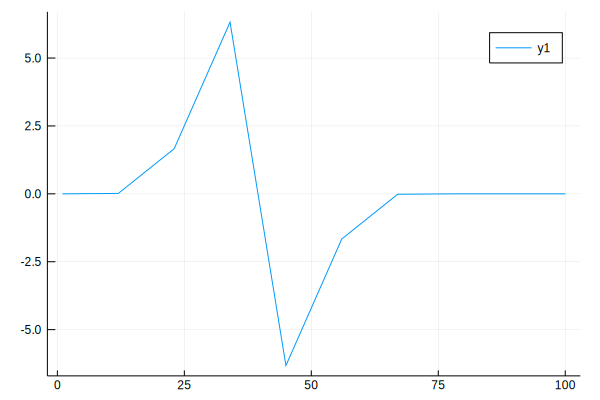

In [24]:
plot([evaluate(r0.u, x) for x in xs])

## To be continued: Time evolution, Calculate errors, Determine convergence factor